# Group O-1-2 (group B) Assignment

### Composed by:
1. Anwita Bhure  
2. Ricardo Gouvea  
3. Andrés Llerena
4. Antoine Moyroud  
5. Breogán Pardo Álvarez
6. Daniel Russotto
7. Caterina Selman

# Lab 16 Assignment 3 - Group Assignment

When creating ML models, the concept of efficiency has three sides:
1. The time dedicated by the analyst to build the model
2. The computer time and resources needed by the final model
3. The accuracy of the final model

Efficiency is a combination of all

In this assignment, you are asked to be efficient. Spark is the best tool to build models over massive datasets

If you need to create Spark+Python Machine Learning models that "run fast" on the  cluster, you must avoid using Python code or working with RRD+python. Try to use  the already existing methods that do what you need (do not reinvent the wheel).

Therefore try to use the implemented object+methods inside the Spark SQL and ML modules. They are very fast, because it is compiled Java/Scala code. Try to use: DataFrames, Feature Transfomers, Estimators, Pipelines, GridSearch, CV, ...

For this assignment, you are asked to create a classification model that:
1. Uses the variables in the dataset (train.csv) to predict label "loan_status"
2. Write a python scripts that:
    - Reads the "train.csv" and "test.csv" files, transform and select variables as you wish.
    - Train/fit your model using the "train.csv".
    - Predict your model on the "test.csv" ( you should generate a file with your predictions).
    - I will use a different test dataset (with the true loan_status).

Your work will be evaluated under the following scoring schema
- (40%) ETL process
- (40%) Model train process
- (10%) Code Readability 
- (10%) AUC on the test set (at least 50%)

Enjoy it and best of luck!!


This Assignment is based on kaggle competition https://www.kaggle.com/c/loan-default-prediction from where a sub-dataset has been taken.

### File descriptions
**train.csv** - the training set (to use for building a model)

**test.csv** - the test set (to use for applying predictings)

**sample_submission.csv** - a template for the submission file

### Data Description (also contained in LendingClub_DataDescription.csv)
**ID**: A unique LC assigned ID for the loan listing.

**loan_amnt**: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

**loan_status**: Current status of the loan (**Target**: 1 = Charged Off, 0 = Fully Paid).

**term**: The number of payments on the loan. Values are in months and can be either 36 or 60.

**int_rate**: Interest Rate on the loan.

**installment**: The monthly payment owed by the borrower if the loan originates.

**emp_length**: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

**home_ownership**: The home ownership status provided by the borrower during registration. Our values are: OTHER/NONE, MORTGAGE, OWN, RENT.

**annual_inc**: The self-reported annual income provided by the borrower during registration.

**purpose**: A category provided by the borrower for the loan request.

**title**: The loan title provided by the borrower.

**STATE**: The state provided by the borrower in the loan application.

**delinq_2yrs**: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.

**revol_bal**: Total credit revolving balance.  revolve a balance -- that is, not pay it off at the end of the month 

**revol_util**: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

**total_pymnt**: Indicates total payment at the end of the loan.

In [1]:
import os
import sys

os.environ['SPARK_HOME'] = "C:\\spark-2.3.2-bin-hadoop2.7\\"

# Create a variable for our root path
SPARK_HOME = os.environ['SPARK_HOME']

#Add the following paths to the system path. Please check your installation
#to make sure that these zip files actually exist. The names might change
#as versions change.
sys.path.insert(0,os.path.join(SPARK_HOME,"python"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","pyspark.zip"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","py4j-0.10.7-src.zip"))

#Initialize SparkSession and SparkContext
from pyspark.sql import SparkSession

#Create a Spark Session
spark = SparkSession \
    .builder \
    .master("local[2]") \
    .appName("MiPrimer") \
    .config("spark.executor.memory", "6g") \
    .config("spark.cores.max","4") \
    .getOrCreate()


#Get the Spark Context from Spark Session    
sc = spark.sparkContext

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql import functions as f
from pyspark.ml.feature import Normalizer, Imputer, StringIndexer, OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.param import Params
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression,LogisticRegressionModel, RandomForestClassifier,GBTClassifier

### 1. Read the files into a Dataframes and show them

In [3]:
loanDF = spark.read.format('csv') \
           .option("inferSchema", "true") \
           .option("header","true")\
           .option("delimiter", ";") \
           .load('../data/train.csv') 

testDF = spark.read.format('csv') \
            .option("inferSchema", "true") \
            .option("header","true")\
            .option("delimiter", ";") \
            .load('../data/test.csv') 

### 2. Analizing null values, cross tables distribution and covariances

#### Null values

In [4]:
#Analyzing the presence of null/missing values
loanDF_empty=loanDF.select([f.count(f.when(col(c).isNull() | f.isnan(c), c)).alias(c) for c in loanDF.columns])
print('Total number of rows = {0}. Total number of null/missing values, per column:'.format(loanDF.count()))
loanDF_empty.toPandas()

Total number of rows = 29755. Total number of null/missing values, per column:


,ID,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,purpose,title,STATE,delinq_2yrs,revol_bal,revol_util,total_pymnt,loan_status
0,0,0,0,0,0,0,0,0,1229,1238,1239,1239,1239,1275,1239,0


#### Cross table distribution

In [5]:
#Analyzing the porportion of each target response (0 or 1) for every categorial variable
cross_list=[x for x in loanDF.columns if x in ['term','emp_length','home_ownership','STATE', 'title']]
[loanDF.crosstab(c,'loan_status').show() for c in cross_list]

+----------------+-----+----+
|term_loan_status|    0|   1|
+----------------+-----+----+
|       60 months| 6203|1846|
|       36 months|19327|2379|
+----------------+-----+----+

+----------------------+----+----+
|emp_length_loan_status|   0|   1|
+----------------------+----+----+
|               5 years|2149| 348|
|               6 years|1435| 235|
|               3 years|2675| 387|
|               8 years| 950| 160|
|                1 year|2097| 343|
|              < 1 year|2968| 478|
|               9 years| 820| 120|
|                   n/a| 622| 170|
|               4 years|2245| 346|
|             10+ years|5599|1006|
|               7 years|1127| 205|
|               2 years|2843| 427|
+----------------------+----+----+

+--------------------------+-----+----+
|home_ownership_loan_status|    0|   1|
+--------------------------+-----+----+
|                     OTHER|   60|   9|
|                       OWN| 1950| 322|
|                  MORTGAGE|11514|1774|
|                 

[None, None, None, None, None]

#### Covariances

In [6]:
def print_corr_matrix(sparkdataframe):
    
    df=sparkdataframe.toPandas()
    
    corr = df.corr()
   
    # Generate a mask for the upper triangle
    mask = np.array(corr)
    mask[np.tril_indices_from(mask)] = False
    fig,ax = plt.subplots(figsize=(15,15))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr,
                cmap=cmap,
                mask=mask,
                vmax=.8, 
                square=True,
                annot=True,
                ax=ax)
    plt.show()
    
def scatter_plot(sparkdataframe):
    df=sparkdataframe.toPandas()
    
    sns.scatterplot(x='installment', y='loan_amnt', data=df,hue='loan_status')
    plt.show()
    sns.scatterplot(x='total_pymnt', y='loan_amnt', data=df,hue='loan_status')
    plt.show()
    sns.scatterplot(x='total_pymnt', y='installment', data=df,hue='loan_status')
    plt.show()
    sns.set(style="white")

The following **correlation matrix** shows the **correlation coefficients between each pair of variables**:  

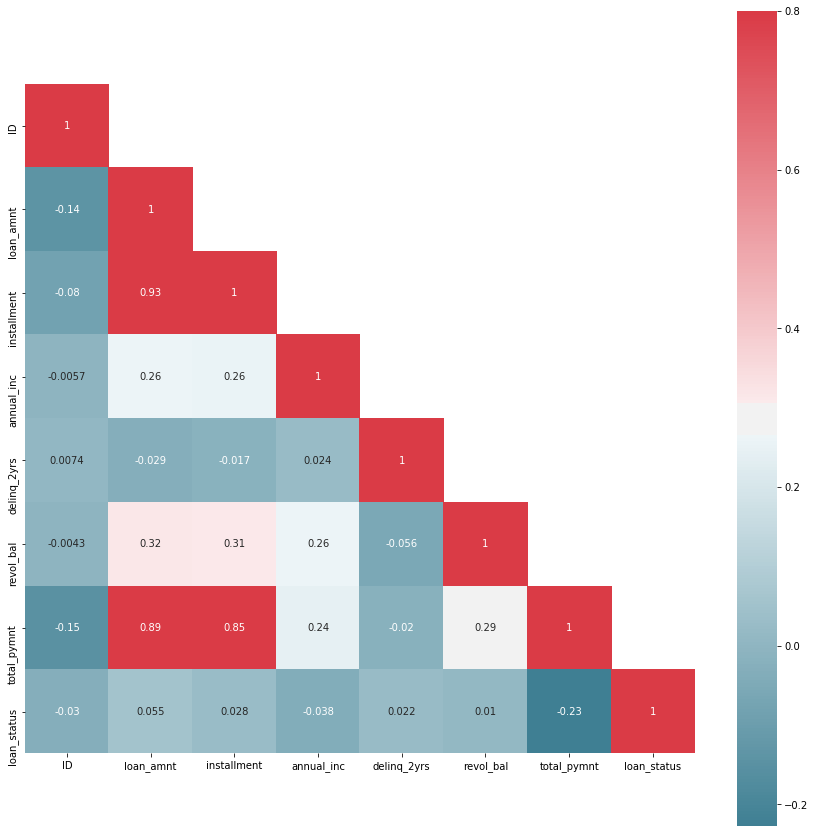

In [7]:
print_corr_matrix(loanDF)

As seen in the aforementioned correlation matrix, there is a high correlation between:
1. installment and loan_amnt (**0.93**)
2. total_pymnt and loan_amnt (**0.89**)
3. total_pymnt and installment  (**0.85**)   

Therefore, **loan_amnt** and **installment** and **total_pymnt** can not be entered the model at the same time.

The following scatter plots confirm the existence of a clearly **high correlation** between these pair of variables.

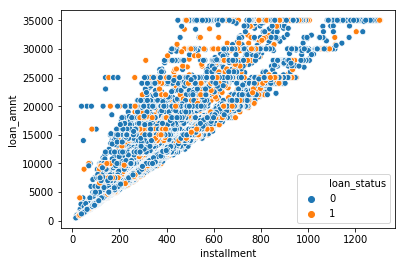

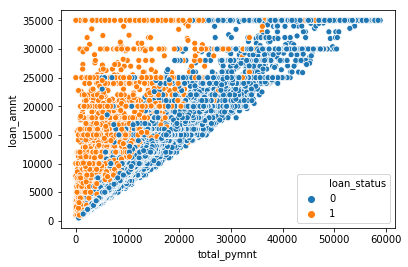

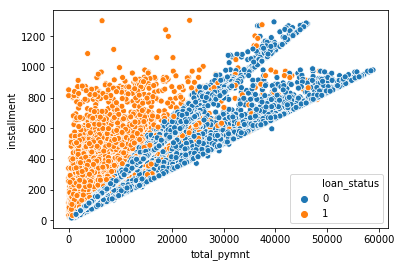

In [8]:
scatter_plot(loanDF)

#### ETL summary

The ETL and preprocessing stage of this project included the following steps:

1. **Deal with data types**: A few variables were not recorded in the correct/proper type, so a cast was needed.   
2. **Create ratio**: To maximize the information obtained from the original features, a new variable, representing the ratio between the installment and the monthly income, was calculated.  
3. **Drop fiels**: Variables with excesive categories (title) or with no logical/business perspective relationship with the target (home_ownership) were discarded.  
4. **Imputation**: Numerical variables with missing/null values were imputed using the median value.
5. **Normalization**: Numerical variables with values in different scales were normalized.  
6. **Re-categorization**: Categorical variables were recoded as indexes.  
7. **One-hot Encoding**: Newly re-categorized variables were one hot encoded (dummy variables).

### 2.1 Spark code about the one explained in "ETL Summary"

In [9]:
#ETL and Preprocessing Stage - Functions definitions

#Data Types
def fix_data_types(data):
    data=data.withColumn('int_rate', col('int_rate').substr(1, 4))\
             .withColumn("int_rate", col("int_rate").cast('float'))\
             .withColumn('revol_util', col('revol_util').substr(1, 4))\
             .withColumn("revol_util", col("revol_util").cast('float'))\
             .withColumn("delinq_2yrs", col("delinq_2yrs").cast('float'))\
             .withColumn("revol_bal", col("revol_bal").cast('float'))
    return data

#Creation of New Variables
def create_ratio(data):
    data=data.withColumn('r_ins_minc',(data['installment']/(data['annual_inc']/12)))
    return data

#Dropping Variables
def drop_fields(data):
    data=data.drop('title','home_ownership')
    return data

def update_df(data, operations):
    for ops in operations:
        data=ops(data)
    return data    

### 2.2 Spark code about the transformations you apply to the variables

In [10]:
#ETL and Preprocessing Stage

stages=[]

#Imputation
empty_values=["delinq_2yrs","revol_bal","revol_util","total_pymnt"]
null_imputer=Imputer()\
        .setStrategy('median')\
        .setInputCols(empty_values)\
        .setOutputCols(empty_values)\

stages.append(null_imputer)

#Normalization
# normalize_list=['revol_bal','total_pymnt','annual_inc']
# for val in normalize_list:
#     normal=Normalizer(inputCol=val,outputCol=val+'_nor')
#     stages.append(normal)

#Recategorization
convert_list=['term','emp_length','STATE','purpose','loan_status']
for val in convert_list:
    if val=='loan_status':
        string_to_index = StringIndexer(inputCol = val, outputCol = val+'_index')
        stages.append(string_to_index)
    else:
        string_to_index = StringIndexer(inputCol = val, outputCol = val+'_index',handleInvalid='keep')
        stages.append(string_to_index)
    
#One-hot Encoding
encoder = OneHotEncoderEstimator(inputCols=["term_index",'emp_length_index','purpose_index','STATE_index'],
                                           outputCols=["term_enc",'emp_length_enc','purpose_enc','STATE_enc'])
stages.append(encoder)

### 2.3 Code to assemble the variables to a numerical vector (VectorAssembler)

In [11]:
#Vector Assembler
assembler = VectorAssembler(inputCols=['annual_inc', 'delinq_2yrs', 'revol_bal', 'revol_util',\
                                        'total_pymnt','r_ins_minc','emp_length_enc','term_enc','purpose_enc','STATE_enc'],\
                            outputCol='features')
stages.append(assembler)

**Elements of Vector Assembler**: Each one of the functions we applied to our dataset 

In [12]:
stages

[Imputer_458490a74fda2d87fffd,
 StringIndexer_43d78b0eecd8057f8790,
 StringIndexer_40b6b4cbc4a910a9556e,
 StringIndexer_428cb68d79336a9e2a20,
 StringIndexer_4477a03a09ae711d392a,
 StringIndexer_48f989cfa86c1d114dce,
 OneHotEncoderEstimator_41b88ffb6dde83f82b4b,
 VectorAssembler_49c5bde3932628d2e1b1]

### 2.4 Create Pipeline for train and test data

In [13]:
#Executing ETL and Preprocessing
preprocessing=[fix_data_types,create_ratio,drop_fields]

#Excecuting Pipeline, which contains VectorAssembler steps:
pipeline=Pipeline(stages=stages)

trainDF=update_df(loanDF,preprocessing)
model=pipeline.fit(trainDF)
trainDF1=model.transform(trainDF)

testDF=update_df(testDF,preprocessing)
testDF1=model.transform(testDF)

Up to this point, **Train and Test datasets are treated and ready** for the Modelling Stage.

In [14]:
trainDF1.toPandas().head(10)

,ID,loan_amnt,term,int_rate,installment,emp_length,annual_inc,purpose,STATE,delinq_2yrs,...,term_index,emp_length_index,STATE_index,purpose_index,loan_status_index,term_enc,emp_length_enc,purpose_enc,STATE_enc,features
0,2,2500,60 months,15.20,59.83,< 1 year,30000.0,car,GA,0.0,...,1.0,1.0,7.0,6.0,1.0,"(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(30000.0, 0.0, 1687.0, 0.09000000357627869, 10..."
1,4,10000,36 months,13.40,339.31,10+ years,49200.0,other,CA,0.0,...,0.0,0.0,0.0,2.0,0.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(49200.0, 0.0, 5598.0, 0.20999999344348907, 12..."
2,5,3000,60 months,12.60,67.79,1 year,80000.0,other,OR,0.0,...,1.0,6.0,24.0,2.0,0.0,"(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(80000.0, 0.0, 27783.0, 0.5299999713897705, 40..."
3,6,5000,36 months,7.90,156.46,3 years,36000.0,wedding,AZ,0.0,...,0.0,3.0,12.0,7.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(36000.0, 0.0, 7963.0, 0.2800000011920929, 563..."
4,7,7000,60 months,15.90,170.08,8 years,47004.0,debt_consolidation,NC,0.0,...,1.0,9.0,15.0,0.0,0.0,"(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(47004.0, 0.0, 17726.0, 0.8500000238418579, 10..."
5,8,3000,36 months,18.60,109.43,9 years,48000.0,car,CA,0.0,...,0.0,10.0,0.0,6.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(48000.0, 0.0, 8221.0, 0.8700000047683716, 393..."
6,10,5375,60 months,12.60,121.45,< 1 year,15000.0,other,TX,0.0,...,1.0,1.0,3.0,2.0,1.0,"(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(15000.0, 0.0, 9279.0, 0.36000001430511475, 14..."
7,11,6500,60 months,14.60,153.45,5 years,72000.0,debt_consolidation,AZ,0.0,...,1.0,5.0,12.0,0.0,0.0,"(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(72000.0, 0.0, 4032.0, 0.20000000298023224, 76..."
8,12,12000,36 months,12.60,402.54,10+ years,75000.0,debt_consolidation,CA,0.0,...,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(75000.0, 0.0, 23336.0, 0.6700000166893005, 13..."
9,14,3000,36 months,9.91,96.68,3 years,15000.0,credit_card,IL,0.0,...,0.0,3.0,5.0,1.0,0.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(15000.0, 0.0, 7323.0, 0.4300000071525574, 348..."


In [15]:
testDF1.toPandas().head(10)

,ID,loan_amnt,term,int_rate,installment,emp_length,annual_inc,purpose,STATE,delinq_2yrs,...,term_index,emp_length_index,STATE_index,purpose_index,loan_status_index,term_enc,emp_length_enc,purpose_enc,STATE_enc,features
0,1,5000,36 months,10.600000,162.87,10+ years,24000.0,credit_card,AZ,0.0,...,0.0,0.0,12.0,1.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(24000.0, 0.0, 13648.0, 0.8399999737739563, 58..."
1,3,2400,36 months,15.900000,84.33,10+ years,12252.0,small_business,IL,0.0,...,0.0,0.0,5.0,5.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(12252.0, 0.0, 2956.0, 0.9900000095367432, 300..."
2,9,5600,60 months,21.200001,152.39,4 years,40000.0,small_business,CA,0.0,...,1.0,4.0,0.0,5.0,1.0,"(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(40000.0, 0.0, 5210.0, 0.33000001311302185, 64..."
3,13,9000,36 months,13.400000,305.38,< 1 year,30000.0,debt_consolidation,VA,0.0,...,0.0,1.0,8.0,0.0,1.0,"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(30000.0, 0.0, 10452.0, 0.9200000166893005, 22..."
4,15,10000,36 months,10.600000,325.74,3 years,100000.0,other,CA,0.0,...,0.0,3.0,0.0,2.0,1.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(100000.0, 0.0, 11997.0, 0.5600000023841858, 7..."
5,18,3600,36 months,6.030000,109.57,10+ years,110000.0,major_purchase,CT,0.0,...,0.0,0.0,16.0,4.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(110000.0, 0.0, 22836.0, 0.1599999964237213, 3..."
6,26,15000,36 months,9.910000,483.38,2 years,92000.0,credit_card,IL,0.0,...,0.0,2.0,5.0,1.0,1.0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(92000.0, 0.0, 13707.0, 0.9399999976158142, 15..."
7,27,15000,36 months,14.200000,514.64,9 years,60000.0,debt_consolidation,NY,0.0,...,0.0,10.0,1.0,0.0,1.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(60000.0, 0.0, 5872.0, 0.5799999833106995, 0.0..."
8,29,4000,36 months,11.700000,132.31,10+ years,106000.0,debt_consolidation,FL,1.0,...,0.0,0.0,2.0,0.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(106000.0, 1.0, 6110.0, 0.3799999952316284, 44..."
9,31,4375,36 months,7.510000,136.11,7 years,17108.0,debt_consolidation,NY,0.0,...,0.0,8.0,1.0,0.0,1.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(17108.0, 0.0, 11210.0, 0.8700000047683716, 48..."


Splitting Train set into **Training** (70%) and **Validation** (30%)

In [16]:
(trainingData, validationData) = trainDF1.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(validationData.count())

20882
8873


### 3. Logistic Regresion Model

### 3.1 Write a function "metrics" which has a LogisticRegressionModel.summary as input attribute and produces an output of: 
1. Area under ROC
2. False Positive Rate By Label
3. True Positive Rate By Label
4. Precision By Label
5. Recall By Label
6. fMeasure By Label
7. Accuracy
8. False Positive Rate
9. True Positive Rate
10. fMeasure
11. Precision
12. Recall

In [17]:
#The fitted model from a Pipeline is a PipelineModel
def metrics(trainingSummary):
    '''This function takes a model that has been fitted (logisticregressionModel) and extracts all metrics'''
    print("   1. Area under ROC: "+str(trainingSummary.areaUnderROC))
    print("   2. False Positive Rate by Label: "+str(trainingSummary.falsePositiveRateByLabel))
    print("   3. True Positive Rate by Label: "+str(trainingSummary.truePositiveRateByLabel))
    print("   4. Precision by Label: "+str(trainingSummary.precisionByLabel))
    print("   5. Recall by Label: "+str(trainingSummary.recallByLabel))
    print("   6. F measure by Label: "+str(trainingSummary.fMeasureByLabel()))
    print("   7. Accuracy: "+str(trainingSummary.accuracy))
    print("   8. False Positive Rate: "+str(trainingSummary.weightedFalsePositiveRate))
    print("   9. True Positive Rate: "+str(trainingSummary.weightedTruePositiveRate))
    print("   10. F measure: ",trainingSummary.weightedFMeasure())
    print("   11. Precision: "+str(trainingSummary.weightedPrecision))
    print("   12. Recall: "+str(trainingSummary.weightedRecall))
    
    return trainingSummary.areaUnderROC

### 3.2 Apply a Logistic Regresion Base Model and show the metrics by the function above

In [18]:
#Logistic Regression Model
lr = LogisticRegression() \
        .setFeaturesCol("features") \
        .setLabelCol("loan_status_index")

lr_model=lr.fit(trainingData)
lr_AUC=metrics(lr_model.summary)

   1. Area under ROC: 0.8646938300326664
   2. False Positive Rate by Label: [0.6070713809206137, 0.01806083650190114]
   3. True Positive Rate by Label: [0.9819391634980988, 0.39292861907938625]
   4. Precision by Label: [0.9060935968216294, 0.7848101265822784]
   5. Recall by Label: [0.9819391634980988, 0.39292861907938625]
   6. F measure by Label: [0.942492955856702, 0.5236719270949101]
   7. Accuracy: 0.8973757302940332
   8. False Positive Rate: 0.5225079477165481
   9. True Positive Rate: 0.8973757302940331
   10. F measure:  0.8823633971828274
   11. Precision: 0.8886810959224064
   12. Recall: 0.8973757302940331


### 3.2 We are going to try to improve our model:
1. Using a `weight column` in our Logistic Regression Model (Take into account we are working with a unbalanced dataset)
2. Define a `ParamGridBuilder` with `regParam`, `elasticNetParam` and `maxIter` at least
3. Define an `BinaryClassificationEvaluator`
4. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:
1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which are the metrics of the best model (training) in the 5 k-fold runs? (Use the function above)
5. Which is the ROC-AUC on validation dataset?

#### Adding a Weight Column, because our dataset is unbalanced

In [19]:
def col_weigths (dataset):
    '''Function that calculates the proportion of 0 and 1 the target variable in order to consider unbalance in the classes'''
    data=dataset.toPandas()
    counts, bin_edges = np.histogram(data['loan_status_index'], bins=2)
    proportion_loan_status_index=pd.DataFrame(counts,index=[0,1],columns=['count'])
    
    proportion_zeros=proportion_loan_status_index.loc[0,'count']
    proportion_ones=proportion_loan_status_index.loc[1,'count']
    
    balancing_ratio=proportion_zeros/dataset.count()
    dataset=dataset.withColumn("classWeights", f.when(dataset.loan_status_index == 1.0,balancing_ratio).otherwise(1-balancing_ratio))
    
    return dataset

In [20]:
trainingData2=col_weigths(trainingData)
validationData2=col_weigths(validationData)

#### Retraining a Logistic Regression, including a Weight Column and Crossvalidation using 5 folds

In [21]:
#Logistic Regression with Weight Col and CV
lr2= LogisticRegression(featuresCol='features', labelCol="loan_status_index",\
                        weightCol='classWeights')

#1. Grid Search: Adjust these parameters
lr_paramGrid = ParamGridBuilder() \
                .addGrid(lr2.regParam, [0.01, 0.5]) \
                .addGrid(lr2.elasticNetParam, [0.0,1.0]) \
                .addGrid(lr2.maxIter, [10,50]) \
                .build()

#2. Evaluator
evaluator = BinaryClassificationEvaluator() \
                .setLabelCol("loan_status_index") \
                .setRawPredictionCol("rawPrediction")

#3. Cross-validation: Create 5-fold CrossValidator
lr_cv = CrossValidator(estimator=lr2, estimatorParamMaps=lr_paramGrid, evaluator=evaluator, numFolds=5)

# Run Cross Validation
lr_cvModel = lr_cv.fit(trainingData2)

#Fit CV model into Training and Validation data
predict_train=lr_cvModel.transform(trainingData2)
predict_val=lr_cvModel.transform(validationData2)

# Evaluating AUC
print("AUC: " + str(evaluator.evaluate(predict_train)))

# Means of model accuracy
print("Means of metrics: " + str(lr_cvModel.avgMetrics[0]))

AUC: 0.8621040919100722
Means of metrics: 0.8556540280930425


#### Logistic Regression with CV improvements:

In [22]:
print('1. Have we improved the ROC-AUC?:',\
     'The improvement with this new model is {}\n'.format(lr_cvModel.avgMetrics[0]-lr_AUC),sep='\n')

print('2. Which are the average ROC-AUC measurements in the different cross validation runs?:',\
      'The average ROC-AUC measurements are {} \n'.format(lr_cvModel.avgMetrics),sep='\n')

print('3. Which are the parameters of the best model in the 5 k-fold runs?:',\
      'The best model parameters are: {} \n'.format(lr_cvModel.bestModel.extractParamMap()),sep='\n')

print('4. Which are the metrics of the best model (training) in the 5 k-fold runs?\n')
metrics(lr_cvModel.bestModel.summary)

print('\n 5. Which is the ROC-AUC on validation dataset? \n')
print('   The ROC-AUC on the validation dataset is: ',evaluator.evaluate(predict_val))

1. Have we improved the ROC-AUC?:
The improvement with this new model is -0.009039801939623948

2. Which are the average ROC-AUC measurements in the different cross validation runs?:
The average ROC-AUC measurements are [0.8556540280930425, 0.8558040968845737, 0.853190461782038, 0.8605610164292825, 0.8053549515289082, 0.8052635958118151, 0.5, 0.5] 

3. Which are the parameters of the best model in the 5 k-fold runs?:
The best model parameters are: {Param(parent='LogisticRegression_4cccb168378568eaa3cb', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LogisticRegression_4cccb168378568eaa3cb', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 1.0, Param(parent='LogisticRegression_4cccb168378568eaa3cb', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: aut

### 4. Random Forest Model
1. Define a `ParamGridBuilder` with `maxDepth`, `numTrees` and `maxIter` at least
2. Define an `BinaryClassificationEvaluator` (You can use the above one)
3. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:

1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which is the importance of the features?
5. Print full description of model.
6. Which is the ROC-AUC on validation dataset?

In [23]:
#Random Forest Model
rf=RandomForestClassifier(featuresCol='features', labelCol="loan_status_index")

#1. Grid Search
# Adjust these parameters: 
rf_paramGrid = ParamGridBuilder() \
                .addGrid(rf.maxDepth, [5,7]) \
                .addGrid(rf.numTrees, [50,100]) \
                .build()

#2. Evaluator
evaluator = BinaryClassificationEvaluator() \
                .setLabelCol("loan_status_index") \
                .setRawPredictionCol("rawPrediction")

#3. Cross-validation: Create 5-fold CrossValidator

rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations
rf_cvModel = rf_cv.fit(trainingData)

# this will likely take a fair amount of time because of the amount of models that we're creating and testing
predict_train_rf=rf_cvModel.transform(trainingData)
predict_val_rf=rf_cvModel.transform(validationData)

# Evaluating AUC
rf_AUC=evaluator.evaluate(predict_train_rf)
print("AUC: " + str(evaluator.evaluate(predict_train_rf)))

# Means of model accuracy
print("Means of metrics: " + str(rf_cvModel.avgMetrics[0]))

AUC: 0.8477132447502065
Means of metrics: 0.7952993213035611


In [24]:
print('1. Have we improved the ROC-AUC?:',\
      ' The improvement with this new model is {} \n'.format(rf_cvModel.avgMetrics[0]-lr_cvModel.avgMetrics[0]),sep='\n')

print('2. Which are the average ROC-AUC measurements in the different cross validation runs?:',\
     ' The average ROC-AUC measurements are {} \n'.format(rf_cvModel.avgMetrics),sep='\n')

print('3. Which are the parameters of the best model in the 5 k-fold runs?:',\
      ' The best model parameters are: {}\n'.format(rf_cvModel.bestModel.extractParamMap()),sep='\n')

print('4. Which is the importance of the features?')
print(rf_cvModel.bestModel.featureImportances,'\n')

print('5. Print full description of model')
print(rf_cvModel.bestModel.toDebugString,'\n')

print('6. Which is the ROC-AUC on validation dataset?')
print('   The ROC-AUC on the validation dataset is: ',evaluator.evaluate(predict_val_rf))

1. Have we improved the ROC-AUC?:
 The improvement with this new model is -0.060354706789481405 

2. Which are the average ROC-AUC measurements in the different cross validation runs?:
 The average ROC-AUC measurements are [0.7952993213035611, 0.7991271111316041, 0.8127909493913084, 0.8200159411433205] 

3. Which are the parameters of the best model in the 5 k-fold runs?:
 The best model parameters are: {Param(parent='RandomForestClassifier_4a2cbb87b6ad507316de', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='RandomForestClassifier_4a2cbb87b6ad507316de', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the

   The ROC-AUC on the validation dataset is:  0.8084051278017138


### 5. Gradient Boosting Model
1. Defining a `ParamGridBuilder` with `maxDepth`, `numTrees` and `maxIter` at least (You can use the above one)
2. Define an `BinaryClassificationEvaluator` (You can use the above one)
3. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:

1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which is the importance of the features?
5. Print full description of model.
6. Which is the ROC-AUC on validation dataset?

In [25]:
#Gradient Boosting Model
gb=GBTClassifier(featuresCol='features', labelCol="loan_status_index")

#1. Grid Search
# Adjust these parameters: 
gb_paramGrid = ParamGridBuilder() \
                .addGrid(gb.maxDepth, [5,7]) \
                .addGrid(gb.maxIter, [10,50]) \
                .build()

#2. Evaluator
evaluator = BinaryClassificationEvaluator() \
                .setLabelCol("loan_status_index") \
                .setRawPredictionCol("rawPrediction")

#3. Cross-validation: Create 5-fold CrossValidator

gb_cv = CrossValidator(estimator=gb, estimatorParamMaps=gb_paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations
gb_cvModel = gb_cv.fit(trainingData)

# this will likely take a fair amount of time because of the amount of models that we're creating and testing
predict_train_gb=gb_cvModel.transform(trainingData)
predict_val_gb=gb_cvModel.transform(validationData)

# Evaluating AUC
print("AUC: " + str(evaluator.evaluate(predict_train_gb)))

# Means of model accuracy
print("Means of metrics: " + str(gb_cvModel.avgMetrics[0]))

AUC: 0.9841257121537117
Means of metrics: 0.88913317269213


In [26]:
print('1. Have we improved the ROC-AUC?:',\
      ' The improvement with this new model is {} \n'.format(gb_cvModel.avgMetrics[0]-rf_cvModel.avgMetrics[0]),sep='\n')

print('2. Which are the average ROC-AUC measurements in the different cross validation runs?:',\
     '  The improvement with this new model is {} \n'.format(gb_cvModel.avgMetrics),sep='\n')

print('3. Which are the parameters of the best model in the 5 k-fold runs?:',\
      '  The best model parameters are: {}\n'.format(gb_cvModel.bestModel.extractParamMap()),sep='\n')

print('4. Which is the importance of the features?')
print(gb_cvModel.bestModel.featureImportances,'\n')

print('5. Print full description of model')
print(gb_cvModel.bestModel.toDebugString,'\n')

print('6. Which is the ROC-AUC on validation dataset?')
print('   The ROC-AUC on the validation dataset is: ',evaluator.evaluate(predict_val_gb))

1. Have we improved the ROC-AUC?:
 The improvement with this new model is 0.09383385138856892 

2. Which are the average ROC-AUC measurements in the different cross validation runs?:
  The improvement with this new model is [0.88913317269213, 0.9210503443374578, 0.9037178988707804, 0.927162195656124] 

3. Which are the parameters of the best model in the 5 k-fold runs?:
  The best model parameters are: {Param(parent='GBTClassifier_496dae36c3896c571693', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='GBTClassifier_496dae36c3896c571693', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10

 

6. Which is the ROC-AUC on validation dataset?
   The ROC-AUC on the validation dataset is:  0.9268020992487006


### 6. Apply your best model to send the predictions on test

Despite Random Forest and Gradient Boosting models being more complex models, **better results were obtained with the Logistic Regression model**. Also, since the model is going to run on a completely different sample, it is preferred not choosing a so complex model because of the **risk of Overfitting**.

In [27]:
#Running LR model on the test dataset
testData2=col_weigths(testDF1)

bestPipelineModel = lr_cvModel.bestModel
finalpred = bestPipelineModel.transform(testData2)

In [28]:
#Displaying final dataset including Prediction
finalpred.toPandas()

,ID,loan_amnt,term,int_rate,installment,emp_length,annual_inc,purpose,STATE,delinq_2yrs,...,loan_status_index,term_enc,emp_length_enc,purpose_enc,STATE_enc,features,classWeights,rawPrediction,probability,prediction
0,1,5000,36 months,10.600000,162.87,10+ years,24000.0,credit_card,AZ,0.0,...,1.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(24000.0, 0.0, 13648.0, 0.8399999737739563, 58...",0.0,"[-0.5181993790409998, 0.5181993790409998]","[0.37327337539419897, 0.626726624605801]",1.0
1,3,2400,36 months,15.900000,84.33,10+ years,12252.0,small_business,IL,0.0,...,1.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(12252.0, 0.0, 2956.0, 0.9900000095367432, 300...",0.0,"[-1.6935096793683584, 1.6935096793683584]","[0.15531484055985695, 0.8446851594401431]",1.0
2,9,5600,60 months,21.200001,152.39,4 years,40000.0,small_business,CA,0.0,...,1.0,"(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(40000.0, 0.0, 5210.0, 0.33000001311302185, 64...",0.0,"[-2.6593780583664755, 2.6593780583664755]","[0.06541334520338792, 0.9345866547966122]",1.0
3,13,9000,36 months,13.400000,305.38,< 1 year,30000.0,debt_consolidation,VA,0.0,...,1.0,"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(30000.0, 0.0, 10452.0, 0.9200000166893005, 22...",0.0,"[-2.2039693472005326, 2.2039693472005326]","[0.09939460630371706, 0.9006053936962829]",1.0
4,15,10000,36 months,10.600000,325.74,3 years,100000.0,other,CA,0.0,...,1.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(100000.0, 0.0, 11997.0, 0.5600000023841858, 7...",0.0,"[0.44500154379507595, -0.44500154379507595]","[0.609450151083517, 0.39054984891648303]",0.0
5,18,3600,36 months,6.030000,109.57,10+ years,110000.0,major_purchase,CT,0.0,...,1.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(110000.0, 0.0, 22836.0, 0.1599999964237213, 3...",0.0,"[0.6318458000072676, -0.6318458000072676]","[0.6529078738533438, 0.3470921261466562]",0.0
6,26,15000,36 months,9.910000,483.38,2 years,92000.0,credit_card,IL,0.0,...,1.0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(92000.0, 0.0, 13707.0, 0.9399999976158142, 15...",0.0,"[1.443223801222518, -1.443223801222518]","[0.808953379158766, 0.19104662084123403]",0.0
7,27,15000,36 months,14.200000,514.64,9 years,60000.0,debt_consolidation,NY,0.0,...,1.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(60000.0, 0.0, 5872.0, 0.5799999833106995, 0.0...",0.0,"[-2.1348305827785574, 2.1348305827785574]","[0.10575727974113179, 0.8942427202588682]",1.0
8,29,4000,36 months,11.700000,132.31,10+ years,106000.0,debt_consolidation,FL,1.0,...,1.0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(106000.0, 1.0, 6110.0, 0.3799999952316284, 44...",0.0,"[0.40403654587993254, -0.40403654587993254]","[0.59965709613759, 0.40034290386241]",0.0
9,31,4375,36 months,7.510000,136.11,7 years,17108.0,debt_consolidation,NY,0.0,...,1.0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [29]:
#Exporting file with ID, Prediction
def export_to_excel(data,name=' Group_B_breogan_pardo_predictions.csv',header=['ID','prediction'],index=False):
    '''Function to export to csv the prediction in the required format ID|prediction'''
    df=data.toPandas()
    df.to_csv(path_or_buf='./'+name,header=header,columns=['ID','prediction'],index=index)

In [30]:
export_to_excel(finalpred)

In [31]:
sc.stop()